# VAE 데이터사이언스 스쿨 관련

'Variational autoencoder'

URL : https://datascienceschool.net/view-notebook/c5248de280a64ae2a96c1d4e690fdf79/

### VAE 최적화를 통해 아래의 두 가지 문제를 푼다.
1. 하나는 주어진 데이터를 잘 설명하는 잠재 변수의 분포를 찾는 것 (Encoder)
2. 잠재변수로부터 원본 이미지와 같은 이미지를 잘 복원하는 것 (Decoder)

# Encoder

이상적인 확률분포 $p(z|x)$를 찾는 것. 어떤 것이 이상적인지 모르니 Variational inference 사용

### Variatinoal inference

이상적인 확률분포를 모르지만 이를 추정하기 위해 다루기 쉬운 분포(approximation class 대표적 Gaussian distribution)를 가정 이 확률분포의 모수를 바꿔가며 이상적인 확률분포에 근사하게 만들어 대신 사용.
다루기 쉬운 분포를 $q_{\phi}$라 한다면 Encoder는 $\phi$라는 파라미터들을 바꿔가며 $q_{\phi}(z|x)$ 확률 분포를 이상적인 $p(z|x)$에 근사키시는 역할을 수행.
보통 $q_{\phi}(\cdot)$은 Gaussian 정규 분포를 가정하며, z의 marginal distribution mean:0, var:1인 표준 정규분포로 가정

Approximation class $q_{\phi}(z|x)$ ->추정-> True Posterior $p(z|x)$

In [1]:
from keras import metrics
from keras import layers
from keras.models import Model
from keras import backend as K
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:

img_shape = (28, 28, 1)
latent_dim = 2

input_layer = layers.Input(shape=img_shape)

e = layers.Conv2D(32, 3, padding='same', activation='relu')(input_layer)
e = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(e)
e = layers.Conv2D(64, 3, padding='same', activation='relu')(e)
e = layers.Conv2D(64, 3, padding='same', activation='relu')(e)

shape_before_flattening = K.int_shape(e)
flat = layers.Flatten()(e)
x = layers.Dense(32, activation='relu')(flat)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
z_mean, z_log_var

(<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'dense_3/BiasAdd:0' shape=(?, 2) dtype=float32>)

In [4]:
shape_before_flattening

(None, 14, 14, 64)

# reparameterization trick

Encoder가 출력하는 것은 $q_{\phi}(z|x)$ 확률 분포의 모수. 우리는 $q_{\phi}(z|x)$를 정규 분포라 가정. 다음 단계는 이 확률 분포를 샘플링하는 것. 그냥하면 back propagation이 불가. Back propagation은 편미분을 통한 Gradient 구하는 것인데 z를 확률 분포에서 샘플링하면 chain rule 끊김 이를 극복하기 위해 Reparameterization trick 사용

reparameterization trick은 가우시안 정규 분포의 샘플을 추출하고 싶을 때 샘플링 하는 방식이 아래와 같다.
이렇게 추출하더라도 원래 확률적 특성 보존. 이렇게 샘플링 하면 z는 확률 분포의 모수인 분산과 평균이 더해진 형태이므로 BackPropagation 가능

$$z^{i,l~}N(\mu, \sigma_i^2) -> z^{i,l}=\mu_i + \sigma_i^2 \odot \epsilon  $$
$$\epsilon^~ N(0,1) $$

In [5]:
def sampling(args):
    
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                             mean=0., stddev=1)
    return z_mean + K.exp(z_log_var) * epsilon

In [6]:
z = layers.Lambda(sampling)([z_mean, z_log_var])

In [7]:
z

<tf.Tensor 'lambda_1/add:0' shape=(?, 2) dtype=float32>

# Decode


추출한 샘플을 입력으로 받아, 다시 원본으로 재구축하는 역할 수행. $\theta$라는 파라미터들을 가지는 $g_\theta(\cdot)$

In [8]:
shape_before_flattening

(None, 14, 14, 64)

In [9]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [10]:
z_decoded

<tf.Tensor 'model_1/conv2d_5/Sigmoid:0' shape=(?, ?, ?, 1) dtype=float32>

# Evidence LowerBOund(ELBO)

궁극적으로 알고 싶은 것은 p(x) 즉 실제 데이터의 분포. $p(z|x), q_\phi(z|x), p(z)$는 p(x)를 추정하기 위해 사용한 도구. 두 가지 방법으로 식을 전개

### Jensen's Inequality

log(p(x))는 확률의 전체확률 법칙에 따라 아래와 같다
$$log(p(x)) = log(\int p(x,z)dz) = log(\int p(x|z)p(z)dz)$$
$q_\phi(z|x)$ 추가
$$log(p(x)) = log(\int p(x|z)\frac{p(z)}{q_\phi(z|x)}q_\phi(z|x)dz)$$
Jensen's Inequality에 의해 아래 부등식 성립
$$log(p(x)) \ge \int log(p(x|z)\frac{p(z)}{q_\phi(z|x)})q_\phi(z|x)dz$$
정리
$$log(p(x)) \ge \int log(p(x|z))q_\phi(z|x)dz - \int log( \frac{q_\phi(z|x)}{p(z)})q_\phi(z|x)dz$$
우 변의 식을 ELBO라 부르며 ELBO($\phi$) 값을 최대화하는 $\phi$를 찾으면 우변과 좌변이 같다.

$$\int log(p(x|z))q_\phi(z|x)dz = E_{q_\phi(z|x)}[log(p(x|z)]$$
$$\int log( \frac{q_\phi(z|x)}{p(z)})q_\phi(z|x)dz = KL(q_\phi(z|x) \parallel p(z))$$

### 최종 
$$ELBO(\phi) = E_{q_\phi(z|x)}[log(p(x|z)] - KL(q_\phi(z|x) \parallel p(z)) $$

### Kullback-Leibler divergence

$\int q_\phi(z|x) dz = 1$
$$log(p(x)) = \int log(p(x))q_\phi(z|x) dz $$

Baysian's rule을 이용 
$$log(p(x)) = \int log( \frac{p(x,z)}{p(z|x)})q_\phi(z|x)dz$$
$$ =\int log( \frac{p(x,z)}{q_\phi(z|x)} \cdot \frac{q_\phi(z|x)}{p(z|x)})q_\phi(z|x)dz $$
$$ =\int log( \frac{p(x,z)}{q_\phi(z|x)})q_\phi(z|x)dz + \int log(\frac{q_\phi(z|x)}{p(z|x)})q_\phi(z|x)dz $$
ELBO 식은 다음과 같이 표현이 가능하다
$$ ELBO(\phi) = \int log( \frac{p(x,z)}{q_\phi(z|x)})q_\phi(z|x)dz$$
$$= \int log(p(x|z)\frac{p(z)}{q_\phi(z|x)})q_\phi(z|x)dz$$

아래 식은 $q_\phi(z|x)$와 $p(z|x)$간의 Kullback-Leibler divergence 값이다.
$$\int log(\frac{q_\phi(z|x)}{p(z|x)})q_\phi(z|x)dz$$

$$log(p(x)) = ELBO(\phi) + KL(q_\phi(z|x) \parallel p(z|x))$$
$ELBO(\phi)$ 최대화, $KL(q_\phi(z|x) \parallel p(z|x))$ 최소화

### 결론 
이상적인 확률 분포 $p(x|z)$를 찾는 것은 $ELBO(\phi)$ 최대화하는 것

$$ELBO(\phi) = E_{q_\phi(z|x)}[log(p(x|z)] - KL(q_\phi(z|x) \parallel p(z)) $$

log(p(x|z)는 z를 입력으로 받아 x를 출력하는 함수로 Decode의 목적과 동일<br>

$log(p_\theta(x|z)$에서 $\theta$ 최대화하는 것은 ELBO를 최대화하는 것

따라서 최종 VAE Loss

$$L_{\theta, \phi; x^i} = - ELBO = - E_{q_\phi(z|x^i)}[log(p_\theta(x^i|z)] + KL(q_\phi(z|x^i) \parallel p(z))$$

Loss 실제 계산


### Loss 실제 계산
1. KL
$$KL(q_\phi(z|x^i) \parallel p(z))$$

Proof
https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions

$q_\phi(z|x^i)$와 $p(z)$를 정규분포로 가정
$$KL(q_\phi(z|x^i) \parallel p(z)) = \frac{1}{2} \Biggl\{tr(\sigma_i^2) + \mu_i^T\mu_i - J + ln \frac{1}{\prod_{j=1}\sigma_{j,j}^2}\Biggl\}$$
$$=\frac{1}{2}\Biggl\{ \sum_{j=1}^J \sigma_{i,j}^2 + \sum_{j=1}^J \mu_{i,j}^2 -J + \sum_{j=1}^J ln(\sigma_{i,j}^2) \Biggl\}$$
$$= \frac{1}{2} \sum_{j=1}^j(\mu_{i,j}^2 + \sigma_{i,j}^2 - ln(\sigma_{i,j}^2) - 1  )$$

정규분포를 가정한 이유는 KL 계산에 있어 정규 분포 이외의 분포를 사용하면 두 분포 간의 KL을 모수만을 사용하여 계산하기 까다롭다.

2.Expectation
$$ E_{q_\phi(z|x^i)}[log(p_\theta(x^i|z)]$$
$$= \int log(p_\theta(x_i|z))q_\phi(z|x_i)dz$$

적분을 해야하지만 Mini-batch 학습 때문에 $q_\phi$로부터 L개의 데이터를 샘플링한 후, Monte-carlo 방식으로 아래와 같이 구한다

$$E_{q_\phi(z|x^i)}[log(p_\theta(x^i|z)] \approx \frac{1}{L}\sum_{z^{i,l}}log(p_\theta(x^i|z^{i,l}))  $$

이 때 $p(x)$를 Bernoulli 분포로 가정하면 $log(p_\theta(x^i|z^{i,l})$ 값은 Cross Entropy 식이 된다.<br>
$p_{i,j}$ 네트워크의 출력값을 의미

$$log(p_\theta(x^i|z^{i,l}) = log\prod_{j=1}^D p_\theta(x_{i,j}|z^i)$$
$$=\sum_{j=1}^D logp_\theta(x_{i,j}|z^i)$$
$$=\sum_{j=1}^D logp_{i,j}^{x_{i,j}}(1-p_{i,j})^{x_{i,j}}$$
$$=\sum_{j=1}^D x_{i,j}logp_{i,j} + (1-x_{i,j})log(1-p_{i,j})$$

In [11]:
class CustomVariationalLayer(layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        cross_entropy_loss = metrics.binary_crossentropy(x,z_decoded)
        
        #kl_loss = 0.5* K.mean(K.square(z_mean) + k.exp(z_log_var) - z_log_var -1, axis=-1)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var) , axis=-1)
        
        return K.mean(cross_entropy_loss + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [12]:
y = CustomVariationalLayer()([input_layer, z_decoded])
y

<tf.Tensor 'custom_variational_layer_1/Identity:0' shape=(?, 28, 28, 1) dtype=float32>

In [13]:
vae = Model(input_layer, y)
vae.compile(optimizer='adam', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [14]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, x_test.shape)

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

(60000, 28, 28) (10000, 28, 28)


In [15]:
%%time
vae.fit(x=x_train, y=None, shuffle=True, epochs=30,
        batch_size=100, validation_data=(x_test, None), verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 11s 177us/step - loss: 0.2632 - val_loss: 0.2116
Epoch 2/30
60000/60000 [==============================] - 7s 116us/step - loss: 0.2048 - val_loss: 0.1998
Epoch 3/30
60000/60000 [==============================] - 7s 124us/step - loss: 0.1981 - val_loss: 0.1954
Epoch 4/30
60000/60000 [==============================] - 8s 128us/step - loss: 0.1941 - val_loss: 0.1919
Epoch 5/30
60000/60000 [==============================] - 8s 139us/step - loss: 0.1914 - val_loss: 0.1913
Epoch 6/30
60000/60000 [==============================] - 8s 141us/step - loss: 0.1894 - val_loss: 0.1889
Epoch 7/30
60000/60000 [==============================] - 8s 141us/step - loss: 0.1877 - val_loss: 0.1873
Epoch 8/30
60000/60000 [==============================] - 8s 140us/step - loss: 0.1862 - val_loss: 0.1859
Epoch 9/30
60000/60000 [=============================

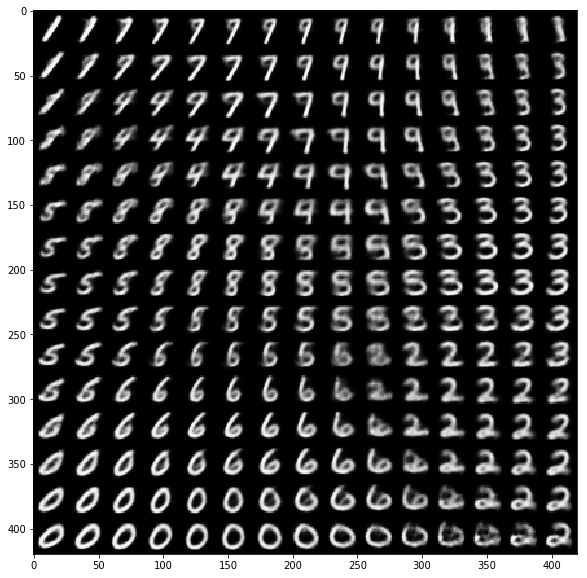

In [16]:
import matplotlib.pyplot as plt
from scipy.stats import norm

batch_size = 150
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)

        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.show()